<a href="https://www.kaggle.com/code/hnaw257/facerecognition-task3-tunning-pca?scriptVersionId=164533942" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split 
from sklearn.datasets import fetch_lfw_people 
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


In [2]:
lfw_people = fetch_lfw_people(min_faces_per_person = 70, funneled=False) 
  
n_samples, h, w = lfw_people.images.shape 
  
X = lfw_people.data 
n_features = X.shape[1] 
  
y = lfw_people.target 
target_names = lfw_people.target_names 
n_classes = target_names.shape[0] 
  
# Print Details about dataset 
print("Number of Data Samples: % d" % n_samples) 
print("Size of a data sample: % d" % n_features) 
print("Number of Class Labels: % d" % n_classes)

Number of Data Samples:  1288
Size of a data sample:  2914
Number of Class Labels:  7


In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42, stratify=y) 

In [4]:
n_components = 150
  
pca = PCA(n_components=n_components)
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)

# Euclidean

In [5]:
y_predict = []
for i in range(len(X_test_reduced)):
    min_ = np.argmin(np.sqrt(np.sum((X_train_reduced - X_test_reduced[i])**2,axis=1)))
    y_predict.append(y_train[min_])

In [6]:
print(classification_report(y_test, y_predict, target_names = target_names)) 

                   precision    recall  f1-score   support

     Ariel Sharon       0.29      0.26      0.28        19
     Colin Powell       0.47      0.54      0.50        59
  Donald Rumsfeld       0.40      0.40      0.40        30
    George W Bush       0.59      0.64      0.62       133
Gerhard Schroeder       0.11      0.07      0.09        27
      Hugo Chavez       0.25      0.11      0.15        18
       Tony Blair       0.37      0.39      0.38        36

         accuracy                           0.47       322
        macro avg       0.36      0.35      0.35       322
     weighted avg       0.45      0.47      0.46       322



****

**Set up dataframe for model results storage**

In [7]:
model_scores = {}
prediction_results = {}

*****

# PCA - TUNNING PROCESS

In [8]:
from sklearn.model_selection import KFold
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Support Vector Machine 

**Normal**

In [9]:
from sklearn.svm import SVC

svm = SVC(kernel='linear')
svm.fit(X_train_reduced, y_train)
y_pred = svm.predict(X_test_reduced)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# One-hot encoding for probability calculation (adapt if necessary)
# Assuming 'label_' prefix for clarity
y_test_onehot = pd.get_dummies(y_test, prefix='label_')
y_pred_onehot = pd.get_dummies(y_pred, prefix='label_')

# ROC AUC score with multiclass handling
roc_auc_macro = roc_auc_score(y_test_onehot, y_pred_onehot,
                              average='macro', multi_class='ovo')  # Specify 'ovo' or 'ovr'

print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
print('roc_auc: ', roc_auc_macro)

accuracy: 0.7701863354037267
recall: 0.6999959880869783
precision: 0.7170788104224636
f1-score: 0.7034159950376918
roc_auc:  0.8287829967696508


**Tunning**

In [10]:
import optuna
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

def objective(trial):
    hyperparams = {
        'kernel': trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly']),
        'C': trial.suggest_loguniform('C', 1e-5, 1e5),
        'gamma': trial.suggest_loguniform('gamma', 1e-5, 1e5),
        # 'degree': trial.suggest_int('degree', 2, 5),  # for polynomial kernel
        'tol': trial.suggest_loguniform('tol', 1e-4, 1e-2),
        'shrinking': trial.suggest_categorical('shrinking', [True, False]),
    }
    
    # Create KNN model with tuned hyperparameters
    model = SVC(**hyperparams)
    scores = cross_val_score(model, X_train_reduced, y_train, cv = kf,scoring = 'accuracy')
    return np.mean(scores)

In [11]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
best_params = study.best_params
print("Best params found :", best_params)

final_model = SVC(**best_params)
final_model.fit(X_train_reduced, y_train)
y_pred = final_model.predict(X_test_reduced)
prediction_results['svc'] = list(y_pred)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# Fit a label binarizer to get all possible classes
label_binarizer = LabelBinarizer()
label_binarizer.fit(y_test)

# Transform y_test and y_pred to one-hot encoding with the same set of columns
y_test_onehot = pd.DataFrame(label_binarizer.transform(
    y_test), columns=label_binarizer.classes_)
y_pred_onehot = pd.DataFrame(label_binarizer.transform(
    y_pred), columns=label_binarizer.classes_)

# Ensure both sets have the same columns
all_columns = set(y_test_onehot.columns).union(set(y_pred_onehot.columns))
y_test_onehot = y_test_onehot.reindex(columns=all_columns, fill_value=0)
y_pred_onehot = y_pred_onehot.reindex(columns=all_columns, fill_value=0)

# ROC AUC score with multiclass handling
roc_auc_macro = roc_auc_score(
    y_test_onehot, y_pred_onehot, average='macro', multi_class='ovo')


print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
print('roc_auc: ', roc_auc_macro)

# Save model result
model_name = 'SVM'
model_scores[model_name] = [accuracy,recall,f1,precision,roc_auc_macro]

[I 2024-02-27 10:32:01,633] A new study created in memory with name: no-name-0cd4e0e6-d3c6-4ccb-b04c-c467ebaf4122
[I 2024-02-27 10:32:02,653] Trial 0 finished with value: 0.41097163613054855 and parameters: {'kernel': 'rbf', 'C': 9.085299801593287, 'gamma': 9.831400360488916, 'tol': 0.0014501593458484216, 'shrinking': True}. Best is trial 0 with value: 0.41097163613054855.
[I 2024-02-27 10:32:03,233] Trial 1 finished with value: 0.5910848779445541 and parameters: {'kernel': 'poly', 'C': 0.0002039433815027836, 'gamma': 13828.145185955347, 'tol': 0.0015892684697276901, 'shrinking': False}. Best is trial 1 with value: 0.5910848779445541.
[I 2024-02-27 10:32:03,589] Trial 2 finished with value: 0.41097163613054855 and parameters: {'kernel': 'linear', 'C': 5.4807309062212135e-05, 'gamma': 4.795597068043059, 'tol': 0.0008392721323234678, 'shrinking': False}. Best is trial 1 with value: 0.5910848779445541.
[I 2024-02-27 10:32:04,224] Trial 3 finished with value: 0.5910848779445541 and paramet

Best params found : {'kernel': 'linear', 'C': 0.16045195894349748, 'gamma': 6696.085885112983, 'tol': 0.0001563403269291464, 'shrinking': True}
accuracy: 0.8167701863354038
recall: 0.7448970826312485
precision: 0.8017136805622412
f1-score: 0.7638142633391973
roc_auc:  0.8548065005457336


In [12]:
print(f'{model_name}\n')
print('=' * 50)
print(classification_report(y_test, y_predict, target_names=target_names))

SVM

                   precision    recall  f1-score   support

     Ariel Sharon       0.29      0.26      0.28        19
     Colin Powell       0.47      0.54      0.50        59
  Donald Rumsfeld       0.40      0.40      0.40        30
    George W Bush       0.59      0.64      0.62       133
Gerhard Schroeder       0.11      0.07      0.09        27
      Hugo Chavez       0.25      0.11      0.15        18
       Tony Blair       0.37      0.39      0.38        36

         accuracy                           0.47       322
        macro avg       0.36      0.35      0.35       322
     weighted avg       0.45      0.47      0.46       322



# Decision Tree

**Normal**

In [13]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_reduced, y_train)
y_pred = dt.predict(X_test_reduced)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# One-hot encoding for probability calculation (adapt if necessary)
# Assuming 'label_' prefix for clarity
y_test_onehot = pd.get_dummies(y_test, prefix='label_')
y_pred_onehot = pd.get_dummies(y_pred, prefix='label_')

# ROC AUC score with multiclass handling
roc_auc_macro = roc_auc_score(y_test_onehot, y_pred_onehot,
                              average='macro', multi_class='ovo')  # Specify 'ovo' or 'ovr'

print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
print('roc_auc: ', roc_auc_macro)

svm = SVC(kernel='linear')
svm.fit(X_train_reduced, y_train)
y_pred = svm.predict(X_test_reduced)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# One-hot encoding for probability calculation (adapt if necessary)
# Assuming 'label_' prefix for clarity
y_test_onehot = pd.get_dummies(y_test, prefix='label_')
y_pred_onehot = pd.get_dummies(y_pred, prefix='label_')

# ROC AUC score with multiclass handling
roc_auc_macro = roc_auc_score(y_test_onehot, y_pred_onehot,
                              average='macro', multi_class='ovo')  # Specify 'ovo' or 'ovr'

print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
print('roc_auc: ', roc_auc_macro)

accuracy: 0.40372670807453415
recall: 0.24745236780409458
precision: 0.24441978224410782
f1-score: 0.2431556000768207
roc_auc:  0.5666798756374157
accuracy: 0.7701863354037267
recall: 0.6999959880869783
precision: 0.7170788104224636
f1-score: 0.7034159950376918
roc_auc:  0.8287829967696508


**Tunning**

In [14]:
import optuna
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')


def objective(trial):
    hyperparams = {
        "max_depth" : trial.suggest_int("max_depth", 2, 10),
        "min_samples_split" : trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf" : trial.suggest_int("min_samples_leaf", 1, 10),
        "criterion" : trial.suggest_categorical("criterion", ["gini", "entropy"]),
        'random_state': trial.suggest_categorical('random_state', [42])

    }

    # Create KNN model with tuned hyperparameters
    model = DecisionTreeClassifier(**hyperparams)
    scores = cross_val_score(model, X_train_reduced,
                             y_train, cv=kf, scoring='accuracy')
    return np.mean(scores)

In [15]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
best_params = study.best_params
print("Best params found :", best_params)

final_model = DecisionTreeClassifier(**best_params)
final_model.fit(X_train_reduced, y_train)
y_pred = final_model.predict(X_test_reduced)
prediction_results['decison tree'] = list(y_pred)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')


# Fit a label binarizer to get all possible classes
label_binarizer = LabelBinarizer()
label_binarizer.fit(y_test)

# Transform y_test and y_pred to one-hot encoding with the same set of columns
y_test_onehot = pd.DataFrame(label_binarizer.transform(
    y_test), columns=label_binarizer.classes_)
y_pred_onehot = pd.DataFrame(label_binarizer.transform(
    y_pred), columns=label_binarizer.classes_)

# Ensure both sets have the same columns
all_columns = set(y_test_onehot.columns).union(set(y_pred_onehot.columns))
y_test_onehot = y_test_onehot.reindex(columns=all_columns, fill_value=0)
y_pred_onehot = y_pred_onehot.reindex(columns=all_columns, fill_value=0)

# ROC AUC score with multiclass handling
roc_auc_macro = roc_auc_score(
    y_test_onehot, y_pred_onehot, average='macro', multi_class='ovo')


print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
print('roc_auc: ', roc_auc_macro)

# Save model result
model_name = 'Decision Tree'
model_scores[model_name] = [accuracy, recall,f1,precision,roc_auc_macro]

[I 2024-02-27 10:32:58,503] A new study created in memory with name: no-name-40c533b8-4b4d-4fac-b79b-f2b739bc981d
[I 2024-02-27 10:32:59,394] Trial 0 finished with value: 0.3943539340847177 and parameters: {'max_depth': 6, 'min_samples_split': 14, 'min_samples_leaf': 7, 'criterion': 'entropy', 'random_state': 42}. Best is trial 0 with value: 0.3943539340847177.
[I 2024-02-27 10:32:59,895] Trial 1 finished with value: 0.3343250894717163 and parameters: {'max_depth': 9, 'min_samples_split': 6, 'min_samples_leaf': 1, 'criterion': 'gini', 'random_state': 42}. Best is trial 0 with value: 0.3943539340847177.
[I 2024-02-27 10:33:01,008] Trial 2 finished with value: 0.3591741894129587 and parameters: {'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 2, 'criterion': 'entropy', 'random_state': 42}. Best is trial 0 with value: 0.3943539340847177.
[I 2024-02-27 10:33:01,569] Trial 3 finished with value: 0.3923348111746167 and parameters: {'max_depth': 3, 'min_samples_split': 11, 'min_sa

Best params found : {'max_depth': 2, 'min_samples_split': 5, 'min_samples_leaf': 7, 'criterion': 'gini', 'random_state': 42}
accuracy: 0.4161490683229814
recall: 0.1803054852627938
precision: 0.10729564553093965
f1-score: 0.13451943161794833
roc_auc:  0.5270774068781686


In [16]:
print(f'{model_name}\n')
print('=' * 50)
print(classification_report(y_test, y_predict, target_names=target_names))

Decision Tree

                   precision    recall  f1-score   support

     Ariel Sharon       0.29      0.26      0.28        19
     Colin Powell       0.47      0.54      0.50        59
  Donald Rumsfeld       0.40      0.40      0.40        30
    George W Bush       0.59      0.64      0.62       133
Gerhard Schroeder       0.11      0.07      0.09        27
      Hugo Chavez       0.25      0.11      0.15        18
       Tony Blair       0.37      0.39      0.38        36

         accuracy                           0.47       322
        macro avg       0.36      0.35      0.35       322
     weighted avg       0.45      0.47      0.46       322



# KNN Classifier

**Normal**

In [17]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train_reduced, y_train)
y_pred = knn.predict(X_test_reduced)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# One-hot encoding for probability calculation (adapt if necessary)
y_test_onehot = pd.get_dummies(y_test, prefix='label_')  # Assuming 'label_' prefix for clarity
y_pred_onehot = pd.get_dummies(y_pred, prefix='label_')

# ROC AUC score with multiclass handling
roc_auc_macro = roc_auc_score(y_test_onehot, y_pred_onehot, average='macro', multi_class='ovo')  # Specify 'ovo' or 'ovr'

print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
print('roc_auc: ', roc_auc_macro)


accuracy: 0.5217391304347826
recall: 0.37513217399161075
precision: 0.47207855129366755
f1-score: 0.3711773145454891
roc_auc:  0.6403036779847798


**Tunning**

In [18]:
import optuna
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

def objective(trial):
    hyperparams = {
        'n_neighbors': trial.suggest_int("n_neighbors", 5, 100),
        'weights' : trial.suggest_categorical("weights", ["uniform", "distance"]),
        'metric' : trial.suggest_categorical("metric", ["euclidean", "manhattan", "minkowski"]),
        'algorithm':trial.suggest_categorical('algorithm',['auto', 'ball_tree', 'kd_tree', 'brute']),
        'n_jobs': -1
    }
    
    # Create KNN model with tuned hyperparameters
    model = KNeighborsClassifier(**hyperparams)
    scores = cross_val_score(model, X_train_reduced, y_train, cv = kf,scoring = 'accuracy')
    return np.mean(scores)

In [19]:
study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 200)
best_params = study.best_params
print("Best params found :", best_params)

final_model =KNeighborsClassifier(**best_params)
final_model.fit(X_train_reduced, y_train)
y_pred = final_model.predict(X_test_reduced)
prediction_results['KNN'] = y_pred 

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')


# Fit a label binarizer to get all possible classes
label_binarizer = LabelBinarizer()
label_binarizer.fit(y_test)

# Transform y_test and y_pred to one-hot encoding with the same set of columns
y_test_onehot = pd.DataFrame(label_binarizer.transform(
    y_test), columns=label_binarizer.classes_)
y_pred_onehot = pd.DataFrame(label_binarizer.transform(
    y_pred), columns=label_binarizer.classes_)

# Ensure both sets have the same columns
all_columns = set(y_test_onehot.columns).union(set(y_pred_onehot.columns))
y_test_onehot = y_test_onehot.reindex(columns=all_columns, fill_value=0)
y_pred_onehot = y_pred_onehot.reindex(columns=all_columns, fill_value=0)

# ROC AUC score with multiclass handling
roc_auc_macro = roc_auc_score(
    y_test_onehot, y_pred_onehot, average='macro', multi_class='ovo')


print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
print('roc_auc: ', roc_auc_macro)

# Save model result
model_name = 'K-Nearest Neighbors'
model_scores[model_name] = [accuracy, recall, f1,precision, roc_auc_macro]

[I 2024-02-27 10:33:32,108] A new study created in memory with name: no-name-80abc163-ccd7-436f-bc5f-d8f6bcd58480
[I 2024-02-27 10:33:32,431] Trial 0 finished with value: 0.46375193632818756 and parameters: {'n_neighbors': 54, 'weights': 'uniform', 'metric': 'minkowski', 'algorithm': 'kd_tree'}. Best is trial 0 with value: 0.46375193632818756.
[I 2024-02-27 10:33:32,618] Trial 1 finished with value: 0.5631323113081567 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'metric': 'manhattan', 'algorithm': 'ball_tree'}. Best is trial 1 with value: 0.5631323113081567.
[I 2024-02-27 10:33:32,756] Trial 2 finished with value: 0.45858127236792906 and parameters: {'n_neighbors': 60, 'weights': 'uniform', 'metric': 'euclidean', 'algorithm': 'auto'}. Best is trial 1 with value: 0.5631323113081567.
[I 2024-02-27 10:33:32,953] Trial 3 finished with value: 0.4875701084343785 and parameters: {'n_neighbors': 38, 'weights': 'distance', 'metric': 'manhattan', 'algorithm': 'ball_tree'}. Best is 

Best params found : {'n_neighbors': 8, 'weights': 'distance', 'metric': 'manhattan', 'algorithm': 'brute'}
accuracy: 0.5962732919254659
recall: 0.3825259611228771
precision: 0.5745190612301089
f1-score: 0.40852600162177716
roc_auc:  0.6469993756088215


In [20]:
print(f'{model_name}\n')
print('=' * 50)
print(classification_report(y_test, y_predict, target_names=target_names))

K-Nearest Neighbors

                   precision    recall  f1-score   support

     Ariel Sharon       0.29      0.26      0.28        19
     Colin Powell       0.47      0.54      0.50        59
  Donald Rumsfeld       0.40      0.40      0.40        30
    George W Bush       0.59      0.64      0.62       133
Gerhard Schroeder       0.11      0.07      0.09        27
      Hugo Chavez       0.25      0.11      0.15        18
       Tony Blair       0.37      0.39      0.38        36

         accuracy                           0.47       322
        macro avg       0.36      0.35      0.35       322
     weighted avg       0.45      0.47      0.46       322



****

# Gaussian NB

**Pre-tunning**

In [21]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train_reduced, y_train)

y_pred = gnb.predict(X_test_reduced)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# One-hot encoding for probability calculation (adapt if necessary)
y_test_onehot = pd.get_dummies(y_test, prefix='label_')  # Assuming 'label_' prefix for clarity
y_pred_onehot = pd.get_dummies(y_pred, prefix='label_')

# # ROC AUC score with multiclass handling
# roc_auc_macro = roc_auc_score(y_test_onehot, y_pred_onehot, average='macro', multi_class='ovr')  # Specify 'ovo' or 'ovr'

print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
# print('roc_auc: ', roc_auc_macro)


accuracy: 0.7204968944099379
recall: 0.6043836386769993
precision: 0.7086164731968175
f1-score: 0.6354442951748511


**Tunning**

In [22]:
def objective(trial):
    hyperparams = {
        'var_smoothing': trial.suggest_float('var_smoothing', 1e-9, 1e-4, log = True)
    }
    
    model = GaussianNB(**hyperparams)
    scores = cross_val_score(model, X_train_reduced, y_train, cv = kf,scoring = 'accuracy')
    return np.mean(scores)

In [23]:
study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 100)
best_params = study.best_params
print("Best params found :", best_params)

final_model = GaussianNB(**best_params)
final_model.fit(X_train_reduced, y_train)
y_pred = final_model.predict(X_test_reduced)
prediction_results['gnb'] = y_pred 

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')


# Fit a label binarizer to get all possible classes
label_binarizer = LabelBinarizer()
label_binarizer.fit(y_test)

# Transform y_test and y_pred to one-hot encoding with the same set of columns
y_test_onehot = pd.DataFrame(label_binarizer.transform(
    y_test), columns=label_binarizer.classes_)
y_pred_onehot = pd.DataFrame(label_binarizer.transform(
    y_pred), columns=label_binarizer.classes_)

# Ensure both sets have the same columns
all_columns = set(y_test_onehot.columns).union(set(y_pred_onehot.columns))
y_test_onehot = y_test_onehot.reindex(columns=all_columns, fill_value=0)
y_pred_onehot = y_pred_onehot.reindex(columns=all_columns, fill_value=0)

# ROC AUC score with multiclass handling
roc_auc_macro = roc_auc_score(
    y_test_onehot, y_pred_onehot, average='macro', multi_class='ovo')


print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
print('roc_auc: ', roc_auc_macro)

# Save model result
model_name = 'Gaussian Naives Bayes'
model_scores[model_name] = [accuracy, recall,f1,precision,roc_auc_macro]

[I 2024-02-27 10:34:07,046] A new study created in memory with name: no-name-4a596b71-ff70-449d-951f-34caf8a042d8
[I 2024-02-27 10:34:07,079] Trial 0 finished with value: 0.6262966721863148 and parameters: {'var_smoothing': 2.5981088314694443e-08}. Best is trial 0 with value: 0.6262966721863148.
[I 2024-02-27 10:34:07,109] Trial 1 finished with value: 0.6262966721863148 and parameters: {'var_smoothing': 4.20981672780366e-07}. Best is trial 0 with value: 0.6262966721863148.
[I 2024-02-27 10:34:07,139] Trial 2 finished with value: 0.6262966721863148 and parameters: {'var_smoothing': 2.1052036174601813e-09}. Best is trial 0 with value: 0.6262966721863148.
[I 2024-02-27 10:34:07,172] Trial 3 finished with value: 0.6262966721863148 and parameters: {'var_smoothing': 1.1749601623802502e-09}. Best is trial 0 with value: 0.6262966721863148.
[I 2024-02-27 10:34:07,202] Trial 4 finished with value: 0.6262966721863148 and parameters: {'var_smoothing': 3.1779516022950344e-07}. Best is trial 0 with 

Best params found : {'var_smoothing': 8.652179946714367e-05}
accuracy: 0.7204968944099379
recall: 0.6043836386769993
precision: 0.7111170188696321
f1-score: 0.6357573076905139
roc_auc:  0.7747350271697669


In [24]:
print(f'{model_name}\n')
print('=' * 50)
print(classification_report(y_test, y_predict, target_names=target_names))

Gaussian Naives Bayes

                   precision    recall  f1-score   support

     Ariel Sharon       0.29      0.26      0.28        19
     Colin Powell       0.47      0.54      0.50        59
  Donald Rumsfeld       0.40      0.40      0.40        30
    George W Bush       0.59      0.64      0.62       133
Gerhard Schroeder       0.11      0.07      0.09        27
      Hugo Chavez       0.25      0.11      0.15        18
       Tony Blair       0.37      0.39      0.38        36

         accuracy                           0.47       322
        macro avg       0.36      0.35      0.35       322
     weighted avg       0.45      0.47      0.46       322



****

# Logistic Regression

**Normal**

In [25]:
lr = LogisticRegression()
lr.fit(X_train_reduced, y_train)
y_pred = lr.predict(X_test_reduced)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# # One-hot encoding for probability calculation (adapt if necessary)
# y_test_onehot = pd.get_dummies(y_test, prefix='label_')  # Assuming 'label_' prefix for clarity
# y_pred_onehot = pd.get_dummies(y_pred, prefix='label_')

# # ROC AUC score with multiclass handling
# roc_auc_macro = roc_auc_score(y_test_onehot, y_pred_onehot, average='macro', multi_class='ovo')  # Specify 'ovo' or 'ovr'

print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
# print('roc_auc: ', roc_auc_macro)

accuracy: 0.8136645962732919
recall: 0.7120723856992495
precision: 0.7760962893682407
f1-score: 0.736171247725812


**Tunning**

In [26]:
import optuna
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')


def objective(trial):
    hyperparams = {
        'solver': trial.suggest_categorical('solver', ['lbfgs', 'liblinear', 'newton-cg', 'saga']),
        'penalty': trial.suggest_categorical('penalty', ['l2']),
        'multi_class': trial.suggest_categorical('multi_class', ['ovr']),
        'C': trial.suggest_loguniform("C", 1e-3, 1e3),
        'n_jobs': -1
    }

    model = LogisticRegression(**hyperparams)
    scores = cross_val_score(model, X_train_reduced,
                             y_train, cv=kf, scoring='accuracy')
    return np.mean(scores)

In [27]:
study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 100)
best_params = study.best_params
print("Best params found :", best_params)

final_model = LogisticRegression(**best_params)
final_model.fit(X_train_reduced, y_train)
y_pred = final_model.predict(X_test_reduced)
prediction_results['logistic regression'] = y_pred 

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')


# Fit a label binarizer to get all possible classes
label_binarizer = LabelBinarizer()
label_binarizer.fit(y_test)

# Transform y_test and y_pred to one-hot encoding with the same set of columns
y_test_onehot = pd.DataFrame(label_binarizer.transform(
    y_test), columns=label_binarizer.classes_)
y_pred_onehot = pd.DataFrame(label_binarizer.transform(
    y_pred), columns=label_binarizer.classes_)

# Ensure both sets have the same columns
all_columns = set(y_test_onehot.columns).union(set(y_pred_onehot.columns))
y_test_onehot = y_test_onehot.reindex(columns=all_columns, fill_value=0)
y_pred_onehot = y_pred_onehot.reindex(columns=all_columns, fill_value=0)

# ROC AUC score with multiclass handling
roc_auc_macro = roc_auc_score(
    y_test_onehot, y_pred_onehot, average='macro', multi_class='ovo')


print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
print('roc_auc: ', roc_auc_macro)

# Save model result
model_name = 'Logistic Regression'
model_scores[model_name] = [accuracy, recall,f1,precision,roc_auc_macro]

[I 2024-02-27 10:34:11,161] A new study created in memory with name: no-name-550ab7fe-5156-4db6-9357-738e3f4929fd
[I 2024-02-27 10:34:13,511] Trial 0 finished with value: 0.7722504139736126 and parameters: {'solver': 'liblinear', 'penalty': 'l2', 'multi_class': 'ovr', 'C': 0.5303278589846548}. Best is trial 0 with value: 0.7722504139736126.
[I 2024-02-27 10:34:18,615] Trial 1 finished with value: 0.7619090860530955 and parameters: {'solver': 'liblinear', 'penalty': 'l2', 'multi_class': 'ovr', 'C': 34.31309071677875}. Best is trial 0 with value: 0.7722504139736126.
[I 2024-02-27 10:34:19,497] Trial 2 finished with value: 0.6366273169168314 and parameters: {'solver': 'liblinear', 'penalty': 'l2', 'multi_class': 'ovr', 'C': 0.00839986749499783}. Best is trial 0 with value: 0.7722504139736126.
[I 2024-02-27 10:34:24,959] Trial 3 finished with value: 0.7536402969926821 and parameters: {'solver': 'liblinear', 'penalty': 'l2', 'multi_class': 'ovr', 'C': 82.25577001326111}. Best is trial 0 wit

Best params found : {'solver': 'liblinear', 'penalty': 'l2', 'multi_class': 'ovr', 'C': 0.5163593686197789}
accuracy: 0.8354037267080745
recall: 0.7382443868616928
precision: 0.8164013789701808
f1-score: 0.7678805930104832
roc_auc:  0.8529974528938961


In [28]:
print(f'{model_name}\n')
print('=' * 50)
print(classification_report(y_test, y_predict, target_names=target_names))

Logistic Regression

                   precision    recall  f1-score   support

     Ariel Sharon       0.29      0.26      0.28        19
     Colin Powell       0.47      0.54      0.50        59
  Donald Rumsfeld       0.40      0.40      0.40        30
    George W Bush       0.59      0.64      0.62       133
Gerhard Schroeder       0.11      0.07      0.09        27
      Hugo Chavez       0.25      0.11      0.15        18
       Tony Blair       0.37      0.39      0.38        36

         accuracy                           0.47       322
        macro avg       0.36      0.35      0.35       322
     weighted avg       0.45      0.47      0.46       322



***

# Random Forest

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

**Normal**

In [30]:
rfr = RandomForestClassifier(random_state=42)
rfr.fit(X_train_reduced,y_train)
y_pred = rfr.predict(X_test_reduced)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# One-hot encoding for probability calculation (adapt if necessary)
y_test_onehot = pd.get_dummies(y_test, prefix='label_')  # Assuming 'label_' prefix for clarity
y_pred_onehot = pd.get_dummies(y_pred, prefix='label_')

# ROC AUC score with multiclass handling
roc_auc_macro = roc_auc_score(y_test_onehot, y_pred_onehot, average='macro', multi_class='ovo')  # Specify 'ovo' or 'ovr'

print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
print('roc_auc: ', roc_auc_macro)

accuracy: 0.5
recall: 0.2166173437359878
precision: 0.474384236453202
f1-score: 0.1962450221528769
roc_auc:  0.4436378532411807


**Tunning**

In [31]:
import optuna


def objective(trial):
    hyperparams = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 10, 50),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 32),
        'random_state': trial.suggest_categorical('random_state', [42]),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 32),
        'n_jobs': -1
    }

    model = RandomForestClassifier(**hyperparams)
    scores = cross_val_score(model, X_train_reduced,
                             y_train, cv=kf, scoring='accuracy')
    return np.mean(scores)

In [32]:
study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 100)
best_params = study.best_params
print("Best params found :", best_params)

final_model = RandomForestClassifier(**best_params)
final_model.fit(X_train_reduced, y_train)
y_pred = final_model.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

[I 2024-02-27 10:38:12,131] A new study created in memory with name: no-name-d513a610-c908-4bdf-be3c-5ff4f585c6e1
[I 2024-02-27 10:38:36,400] Trial 0 finished with value: 0.451359435927568 and parameters: {'n_estimators': 718, 'max_depth': 49, 'min_samples_split': 9, 'random_state': 42, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.451359435927568.
[I 2024-02-27 10:38:46,825] Trial 1 finished with value: 0.4182255221409113 and parameters: {'n_estimators': 394, 'max_depth': 13, 'min_samples_split': 27, 'random_state': 42, 'min_samples_leaf': 30}. Best is trial 0 with value: 0.451359435927568.
[I 2024-02-27 10:39:05,744] Trial 2 finished with value: 0.4182255221409113 and parameters: {'n_estimators': 721, 'max_depth': 45, 'min_samples_split': 24, 'random_state': 42, 'min_samples_leaf': 28}. Best is trial 0 with value: 0.451359435927568.
[I 2024-02-27 10:39:17,383] Trial 3 finished with value: 0.4192617915709631 and parameters: {'n_estimators': 429, 'max_depth': 31, 'min_samples_s

Best params found : {'n_estimators': 953, 'max_depth': 21, 'min_samples_split': 3, 'random_state': 42, 'min_samples_leaf': 1}


0.4968944099378882

In [33]:
final_model = RandomForestClassifier(**best_params)
final_model.fit(X_train_reduced, y_train)
y_pred = final_model.predict(X_test_reduced)
prediction_results['random forest'] = y_pred 

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')


# Fit a label binarizer to get all possible classes
label_binarizer = LabelBinarizer()
label_binarizer.fit(y_test)

# Transform y_test and y_pred to one-hot encoding with the same set of columns
y_test_onehot = pd.DataFrame(label_binarizer.transform(
    y_test), columns=label_binarizer.classes_)
y_pred_onehot = pd.DataFrame(label_binarizer.transform(
    y_pred), columns=label_binarizer.classes_)

# Ensure both sets have the same columns
all_columns = set(y_test_onehot.columns).union(set(y_pred_onehot.columns))
y_test_onehot = y_test_onehot.reindex(columns=all_columns, fill_value=0)
y_pred_onehot = y_pred_onehot.reindex(columns=all_columns, fill_value=0)

# ROC AUC score with multiclass handling
roc_auc_macro = roc_auc_score(
    y_test_onehot, y_pred_onehot, average='macro', multi_class='ovo')


print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
print('roc_auc: ', roc_auc_macro)

# Save model result
model_name = 'Random Forest'
model_scores[model_name] = [accuracy, recall,f1,precision,roc_auc_macro]

accuracy: 0.4968944099378882
recall: 0.20977939198278178
precision: 0.3450491307634165
f1-score: 0.18309371950241182
roc_auc:  0.5437715436184857


In [34]:
print(f'{model_name}\n')
print('=' * 50)
print(classification_report(y_test, y_predict, target_names=target_names))

Random Forest

                   precision    recall  f1-score   support

     Ariel Sharon       0.29      0.26      0.28        19
     Colin Powell       0.47      0.54      0.50        59
  Donald Rumsfeld       0.40      0.40      0.40        30
    George W Bush       0.59      0.64      0.62       133
Gerhard Schroeder       0.11      0.07      0.09        27
      Hugo Chavez       0.25      0.11      0.15        18
       Tony Blair       0.37      0.39      0.38        36

         accuracy                           0.47       322
        macro avg       0.36      0.35      0.35       322
     weighted avg       0.45      0.47      0.46       322



****

****

# SUMMARY

**Classification over all models**

In [35]:
results_df = pd.DataFrame(model_scores, index=['Accuracy', 'Recall','F1 Score','Precision','ROC AUC']).T
results_df

,Accuracy,Recall,F1 Score,Precision,ROC AUC
SVM,0.816770,0.744897,0.763814,0.801714,0.854807
Decision Tree,0.416149,0.180305,0.134519,0.107296,0.527077
K-Nearest Neighbors,0.596273,0.382526,0.408526,0.574519,0.646999
Gaussian Naives Bayes,0.720497,0.604384,0.635757,0.711117,0.774735
Logistic Regression,0.835404,0.738244,0.767881,0.816401,0.852997
Random Forest,0.496894,0.209779,0.183094,0.345049,0.543772


In [36]:
# dump prediction results
# import json
# with open("/kaggle/working/predict.json", "w") as json_file:
#     json.dump(prediction_results, json_file)

****
# Visualization

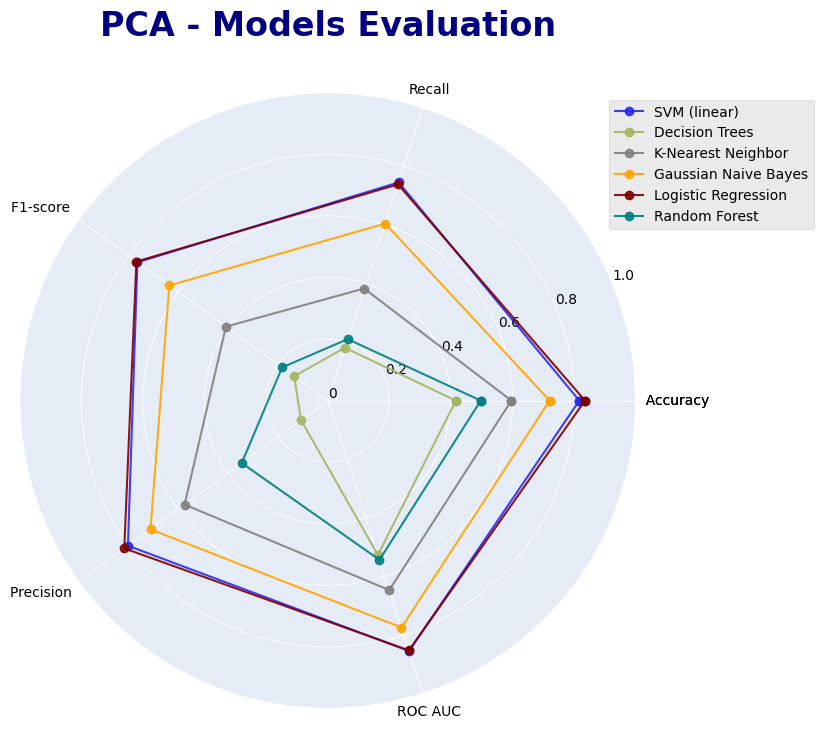

In [37]:
plt.style.use('ggplot')
# Data
labels = [(' '*10 +'Accuracy'), 'Recall', ('F1-score'+ ' ' * 10) , ('Precision'+ ' ' * 10), 'ROC AUC']
svm = results_df.loc['SVM'].tolist()
dt = results_df.loc['Decision Tree'].tolist()
knn = results_df.loc['K-Nearest Neighbors'].tolist()
gnb = results_df.loc['Gaussian Naives Bayes'].tolist()
lr = results_df.loc['Logistic Regression'].tolist()
rf = results_df.loc['Random Forest'].tolist()

# Number of variables we're plotting.
categories = labels
N = len(categories)

# What will be the angle of each axis in the plot?
angles = np.linspace(0, 2*np.pi, len(labels), endpoint = False)
angles = np.concatenate((angles, [angles[0]]))


# Initialise the spider plot
plt.figure(figsize=(8, 8))  # Increase the size of the radar

# Draw one axe per variable + add labels yet
plt.xticks(angles[:-1], categories, color='white')  # White labels
plt.yticks([i/10 for i in range(11)], ["{:.2f}".format(i/10) for i in range(11)], color="white", size=7)
plt.ylim(0, 1)

# Set gray background
ax = plt.subplot(111, polar=True, facecolor='#E6ECF5', alpha = 0.7)  

# Plot each classifier's data
for data, label, color in zip([svm, dt, knn, gnb, lr, rf],
                              ["SVM (linear)", "Decision Trees", "K-Nearest Neighbor",
                               "Gaussian Naive Bayes", "Logistic Regression", "Random Forest"],
                              ['#292AF4', '#A3B763', '#818181', 'orange', 'maroon', 'teal']):
 
    ax.plot(angles, data + data[:1], 'o-', linewidth=1.5, label=label, color=color, alpha = 0.9)
    ax.fill(angles, data + data[:1], alpha=0)  # Fill only the edges
    
# Modify grids
labels.append(labels[0])
ax.set_thetagrids(angles * 180/np.pi, labels, color = 'black')
plt.grid(True)

# Add labels for each coordinate system
# for angle, lab in zip(angles, labels):
# plt.annotate(labels[0], xy=(angles[0], 1.1), color='white', fontsize=10, ha='center')
# plt.annotate(labels[1], xy=(angles[1], 1.1), color='white', fontsize=10, ha='center')
# plt.annotate(labels[2], xy=(angles[2], 1.1), color='white', fontsize=10, ha='center')
# plt.annotate(labels[3], xy=(angles[3], 1.1), color='white', fontsize=10, ha='center')

plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.title("PCA - Models Evaluation\n", size = 24,color='navy', weight = 'bold')
plt.grid(color='white', linestyle='-', alpha = 0.8)  # White grid lines
plt.yticks([0,0.2, 0.4, 0.6, 0.8, 1.0], ["0","0.2", "0.4", "0.6", "0.8", "1.0"],color="black", size=10)  # Custom y-ticks
plt.show()


In [38]:
# dump prediction results
import json
predictions = {}
for k in prediction_results.keys():
    predictions[k] = list(prediction_results[k])

# with open("/kaggle/working/prediction_results.json", "w") as json_file:
#     json.dump(predictions, json_file)

predictions

{'svc': [1,
  1,
  3,
  3,
  1,
  3,
  3,
  3,
  3,
  1,
  3,
  0,
  6,
  5,
  3,
  3,
  3,
  5,
  4,
  3,
  3,
  2,
  1,
  4,
  1,
  1,
  1,
  3,
  3,
  1,
  1,
  3,
  2,
  1,
  2,
  3,
  2,
  1,
  1,
  3,
  0,
  1,
  1,
  1,
  5,
  6,
  3,
  2,
  3,
  2,
  3,
  0,
  1,
  1,
  3,
  0,
  3,
  4,
  3,
  3,
  1,
  5,
  3,
  3,
  1,
  3,
  3,
  1,
  6,
  3,
  1,
  3,
  1,
  2,
  3,
  6,
  6,
  3,
  6,
  3,
  3,
  1,
  3,
  1,
  0,
  4,
  2,
  1,
  5,
  3,
  3,
  2,
  6,
  3,
  3,
  1,
  2,
  3,
  2,
  3,
  1,
  3,
  3,
  3,
  6,
  3,
  3,
  1,
  3,
  3,
  1,
  5,
  3,
  3,
  3,
  6,
  3,
  1,
  6,
  3,
  0,
  1,
  1,
  3,
  2,
  2,
  1,
  3,
  3,
  3,
  5,
  6,
  2,
  2,
  1,
  0,
  3,
  3,
  3,
  0,
  1,
  3,
  3,
  3,
  1,
  2,
  6,
  3,
  6,
  3,
  1,
  1,
  0,
  2,
  2,
  3,
  3,
  3,
  6,
  3,
  3,
  6,
  6,
  3,
  3,
  3,
  3,
  3,
  1,
  3,
  3,
  3,
  2,
  3,
  2,
  2,
  1,
  1,
  3,
  3,
  0,
  1,
  3,
  6,
  2,
  6,
  4,
  4,
  3,
  6,
  0,
  3,
  0,
  2,
  3,
  3,
  4,
  3,
  1